In [1]:
# NEED TO HAVE DATA FILES DOWNLOADED AND UPDATE PATHS

import math
import numpy as np
from numpy import trapz
import pandas as pd
import matplotlib.pyplot as plt
# 
colorset = [    [0, 0.4470, 0.7410],
                [0.8500, 0.3250, 0.0980], 
                [0.9290, 0.6940, 0.1250],
                [0.4940, 0.1840, 0.5560],
                [0.4660, 0.6740, 0.1880],
                [0.3010, 0.7450, 0.9330],
                [0.6350, 0.0780, 0.1840],
                [0, 0.4470, 0.7410],
                [0.8500, 0.3250, 0.0980],
                [0.9290, 0.6940, 0.1250]
]

gamma_E = 0.5772156649015329 # supposed to import math and use math.euler_gamma but did not work -- constant
Qc = 0.0217   # Scientist inputs -- see email for meaning of most vars
energy = 14400
alpha_i = 0.0728
Ddet = 710
pixel = 0.172
footprint = 10
wavelength = 12404/energy
qxy0 = np.array([0.04, 0.06, 0.10, 0.15, 0.318])
qxy0_select_idx = 0 # needs to follow Python indexing; -1 value of MATLAB
qxy_bkg = 0.3
RqxyHW = 0.0002
DSresHW = 0.003
DSpxHW = 3.5      # End of Scientist Inputs

path_xrr = "testing_data/" #     -- should be files to compare with pseudo XRR
xrr_datafile = "XRR-10mM_CaCl2_pH7p03_100ppm_PFOA_1.txt"
xrr_data = pd.read_csv(path_xrr + xrr_datafile, delim_whitespace=True)

path = "testing_data/CaCl2_data/"         # decided by user for where the files should be from and stored
path_out = "testing_data/output/" # decided by user for where the output files should be stored
sample = "instrument"
scan = np.arange(46392, 46401, 2)
bkgsample = 'instrument'
bkgscan = scan+1

I0ratio_sample2bkg = 1; 
kb = 1.381E-23 # Boltzmann constant, J/K
tension = 50/1000 # tension, [N/m]
kappa = 20
temperature = 293 # [K]
Lk = math.sqrt(kappa*kb*temperature/tension)*10**10
amin = 5 # minimal wavelength cutoff of the surface CW
qmax = np.pi / amin
# incorrect_roughness = [2.1]  # [A] roughness incorrectly determined from DS without considering DS/RRF
# intrinsic_roughness = 1 # [A]
# sind_alpha_i = math.sin(math.radians(alpha_i))
RFscaling = I0ratio_sample2bkg* 1*10**11*55/3 /6.8 *(math.pi/180)**2 * (9.42E-6)**2 / math.sin(math.radians(alpha_i))*4

In [2]:
# ~~~  Chen Shen Functions: ~~~     # can paste functions into a separate py file and import
import scipy
from scipy.integrate import trapezoid, simpson
from scipy.special import kv as besselk, jv as besselj, gamma
from scipy.constants import pi, Boltzmann as kb
#from numba import njit
#@jit(nopython=True, parallel=True)  # Use Numba for performance optimization
from scipy.integrate import quad # ChatGPT contribution to replace the integration with quad for better performance


def film_correlation_integrand_replacement(r, qxy, eta, Lk, amin): # Changes made
    r = np.asarray(r)  # Ensure r is a numpy array
    rad_term = np.sqrt(r[None, None, :]**2 + amin**2)  # r turned into r[None, None, :] b/c sizing errors when integrating and the [..., None] at the end was removed
    term1 = rad_term**(1 - eta[..., None])
    term2 = np.exp(-eta[..., None] * besselk(0, rad_term / Lk)) - 1
    term3 = besselj(0, rad_term * qxy[..., None])
    return term1 * term2 * term3




def film_integral_delta_beta_delta_phi(beta, phi, kbT_gamma, wave_number, alpha, Lk, amin):   # error arrises here
    beta = np.asarray(beta) # converting to numpy array for performance/vectorization
    phi = np.asarray(phi)


    qmax = pi / amin
    beta_rad = np.radians(beta)
    phi_rad = np.radians(phi)
    alpha_rad = np.radians(alpha)

    cosb = np.cos(beta_rad)
    sinb = np.sin(beta_rad)
    cosp = np.cos(phi_rad)
    sinp = np.sin(phi_rad)
    cosa = np.cos(alpha_rad)
    sina = np.sin(alpha_rad)

    qxy = wave_number * np.sqrt((cosb * sinp)**2 + (cosa - cosb * cosp)**2)
    qz = wave_number * (sina + sinb)
    eta = (kbT_gamma / (2 * pi)) * qz**2

    r_vals = np.linspace(0.001, 8 * Lk, 300)
    integrand_vals = film_correlation_integrand_replacement(r_vals, qxy, eta, Lk, amin)
    integral_vals = trapezoid(integrand_vals, r_vals, axis=-1) # might need axis = 1
    C_prime = 2 * pi * integral_vals

    xi = 2 ** (1 - eta) * gamma(1 - 0.5 * eta) / gamma(0.5 * eta) * (2 * np.pi) / (qz ** 2)    # xi used to = (2 * Lk) ** eta, but in MATLAB looks like: xi = (2.^(1-eta).*gamma(1-0.5*eta)./gamma(0.5*eta)) *2*pi./qz.^2;

    exp_term = np.exp(eta * besselk(0, 1 / (Lk * qmax)))
    result = (xi * qxy ** (eta - 2) + C_prime / qz**2) * (1 / qmax) ** eta * exp_term
    return result


def film_integral_approx_delta_beta_delta_phi(beta, phi, kbT_gamma, wave_number, alpha, Lk, amin):
    qmax = pi / amin
    beta_rad = np.radians(beta)
    phi_rad = np.radians(phi)
    alpha_rad = np.radians(alpha)

    cosb = np.cos(beta_rad)
    sinb = np.sin(beta_rad)
    cosp = np.cos(phi_rad)
    sinp = np.sin(phi_rad)
    cosa = np.cos(alpha_rad)
    sina = np.sin(alpha_rad)

    qxy = wave_number * np.sqrt((cosb * sinp)**2 + (cosa - cosb * cosp)**2)
    qz = wave_number * (sina + sinb)
    eta = (kbT_gamma / (2 * pi)) * qz**2

    # Safeguard against divide-by-zero or underflow
    qxy = np.maximum(qxy, 1e-12)
    safe_besselk_arg = np.maximum(1 / (Lk * qmax), 1e-12)
    #   

    result = kbT_gamma * (1 / qmax)**eta * np.exp(eta * besselk(0, safe_besselk_arg)) * qxy**eta / (qxy**2 + (Lk**2) * qxy**4)
    return result


# -------------------- Main Calculation -------------------- #

def calc_film_DS_RRF_integ(beta_space, qxy0, energy, alpha, Rqxy_HWHM, DSqxy_HWHM, DSbeta_HWHM,
                           tension, temp, kapa, amin, use_approx=False, show_plot=True):
    qmax = pi / amin
    wavelength = 12.4 / energy
    wave_number = 2 * pi / wavelength
    qz_space = (np.sin(np.radians(alpha)) + np.sin(np.radians(beta_space))) * wave_number

    phi = 2 * np.degrees(np.arcsin(qxy0 / (2 * wave_number)))
    phi_HWHM = np.degrees(DSqxy_HWHM * wavelength / (2 * pi))
    phi_upper = phi + phi_HWHM
    phi_lower = phi - phi_HWHM

    beta_upper = beta_space + DSbeta_HWHM
    beta_lower = beta_space - DSbeta_HWHM

    kbT_gamma = kb * temp / tension * 1e20
    Lk = np.sqrt(kapa * kb * temp / tension) * 1e10
    eta = (kbT_gamma / (2 * pi)) * qz_space**2

    xi = (2 ** (1 - eta)) * (gamma(1 - 0.5 * eta) / gamma(0.5 * eta)) * 2 * pi / qz_space**2

    r_vals = np.linspace(0.001, 8 * round(Lk), 1000)
    r_grid = np.sqrt(r_vals**2 + amin**2)
    C_integrand = np.zeros((len(qz_space), len(r_vals)))

    for idx, eta_val in enumerate(eta):
        C_integrand[idx, :] = 2 * pi * r_grid**(1 - eta_val) * (np.exp(-eta_val * besselk(0, r_grid / Lk)) - 1)

    C = trapezoid(C_integrand, r_vals, axis=1)
    RRF_term = ((xi / kbT_gamma) * Rqxy_HWHM**eta + Rqxy_HWHM**2 * C / (4 * pi)) * (1 / qmax)**eta * np.exp(eta * besselk(0, 1 / (Lk * qmax)))

    DS_term = np.zeros(len(beta_space))
    phi_grid = np.linspace(phi_lower, phi_upper, 100)

    for idx, beta in enumerate(beta_space):
        beta_grid = np.linspace(beta_lower[idx], beta_upper[idx], 100)
        beta_mesh, phi_mesh = np.meshgrid(beta_grid, phi_grid, indexing='ij')

        if use_approx:
            vals = film_integral_approx_delta_beta_delta_phi(beta_mesh, phi_mesh, kbT_gamma, wave_number, alpha, Lk, amin)
        else:
            vals = film_integral_delta_beta_delta_phi(beta_mesh, phi_mesh, kbT_gamma, wave_number, alpha, Lk, amin)

        DS_term[idx] = simpson(simpson(vals, phi_grid), beta_grid)

    DS_RRF = DS_term / RRF_term

    if show_plot:
        label_mode = "Approx" if use_approx else "Accurate"
        plt.figure(figsize=(8, 5))
        plt.plot(qz_space, DS_RRF / DS_RRF[0], label=f"{label_mode} Qxy₀={qxy0:.3f} Å⁻¹", linewidth=1.5)
        plt.xlabel(r"$Q_z$ [$\AA^{-1}$]", fontsize=12)
        plt.ylabel(r"DS / (R/R$_F$)", fontsize=12)
        plt.xlim(0, 1.2)
        plt.grid(True)
        plt.legend(loc="upper left", frameon=False)
        plt.title(f"GIXOS factor ({label_mode})")
        plt.tight_layout()
        plt.show()

    return DS_RRF, DS_term, RRF_term

# -------------------- CLI -------------------- #

# if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Calculate DS / (R/RF) for fluctuating films.")
    parser.add_argument("--beta-csv", type=str, help="CSV file containing beta_space (in degrees)")
    parser.add_argument("--beta-array", type=str, help="Comma-separated list of beta values (e.g., 0,0.1,0.2)")
    parser.add_argument("--qxy0", type=float, required=True, help="qxy at beta = 0")
    parser.add_argument("--energy", type=float, required=True, help="X-ray energy [keV]")
    parser.add_argument("--alpha", type=float, required=True, help="Incident angle [deg]")
    parser.add_argument("--Rqxy_HWHM", type=float, required=True, help="Specular qxy HWHM")
    parser.add_argument("--DSqxy_HWHM", type=float, required=True, help="Diffuse qxy HWHM")
    parser.add_argument("--DSbeta_HWHM", type=float, required=True, help="Diffuse beta HWHM [deg]")
    parser.add_argument("--tension", type=float, required=True, help="Surface tension [N/m]")
    parser.add_argument("--temp", type=float, required=True, help="Temperature [K]")
    parser.add_argument("--kapa", type=float, required=True, help="Bending modulus [kBT]")
    parser.add_argument("--amin", type=float, required=True, help="Cutoff length amin [Angstrom]")
    parser.add_argument("--use-approx", action="store_true", help="Use approximate formula instead of full integration")

    args = parser.parse_args()
    
    if args.beta_csv:
        beta_space = np.loadtxt(args.beta_csv, delimiter=",")
    elif args.beta_array:
        beta_space = np.array([float(b) for b in args.beta_array.split(",")])
    else:
        raise ValueError("You must provide either --beta-csv or --beta-array")
    
    calc_film_DS_RRF_integ(beta_space, args.qxy0, args.energy, args.alpha,
                           args.Rqxy_HWHM, args.DSqxy_HWHM, args.DSbeta_HWHM,
                           args.tension, args.temp, args.kapa, args.amin,
                           use_approx=args.use_approx)
# idea is to be used for command line, but for testing purposes, you can call the function directly and comment out CLI
# beta = [8, 7.95, ... , 0.05]
# qxy0 = 0.04
# energy = 14400
# test calc_film_DS_RRF_integ() function between MATLAB and Python
# if fails, replace vectorization with loops and try again
# GIXOS_fresnel & GIXOS_Tsqr functions are working

def GIXOS_fresnel(Qz, Qc):    # apparently does not limit to 1 like MATLAB code does - see AI
    Qz = np.asarray(Qz, dtype=np.complex128)  # allow complex arithmetic
    sqrt_term = np.sqrt(Qz**2 - Qc**2)        # may be complex when Qz < Qc
    r = (Qz - sqrt_term) / (Qz + sqrt_term)   # reflection coefficient
    refl = np.abs(r)**2                       # reflectivity (real-valued)
    return np.column_stack((Qz.real, refl))   # return Qz as real part only


def GIXOS_dQz(Qz, energy_eV, alpha_i_deg, Ddet_mm, footprint_mm):
    planck = 1240.4  # eV·nm
    wavelength = planck / energy_eV * 10  # Å

    Qz = np.asarray(Qz).reshape(-1, 1)
    dQz = np.zeros((Qz.shape[0], 6)) # change np.zeros((Qz.shape[0], 5)) to np.zeros((Qz.shape[0], 6)) to match MATLAB output and produce 6 columns
    dQz[:, 0] = Qz[:, 0]

    alpha_i_rad = np.radians(alpha_i_deg)
    alpha_f_center = np.degrees(np.arcsin(Qz[:, 0] * wavelength / (2 * np.pi) - np.sin(alpha_i_rad)))
    alpha_f_max = np.degrees(np.arctan(np.tan(np.radians(alpha_f_center)) * Ddet_mm / (Ddet_mm - footprint_mm)))
    alpha_f_min = np.degrees(np.arctan(np.tan(np.radians(alpha_f_center)) * Ddet_mm / (Ddet_mm + footprint_mm)))

    factor = (2 * np.pi) / wavelength
    qz_max = (np.sin(np.radians(alpha_f_max)) + np.sin(alpha_i_rad)) * factor
    qz_min = (np.sin(np.radians(alpha_f_min)) + np.sin(alpha_i_rad)) * factor
    delta_qz = 0.5 * (qz_max - qz_min)

    dQz[:, 1] = alpha_f_center
    dQz[:, 2] = alpha_f_max
    dQz[:, 3] = alpha_f_min
    dQz[:, 4] = delta_qz
    dQz[:, 5] = dQz[:, 4] / dQz[:, 0] # added to match MATLAB output and create new column

    return dQz


def vineyard_factor(alpha_f_deg, energy_eV, alpha_i_deg):
    import numpy as np
    planck = 1240.4  # eV·nm
    qc = 0.0218
    beta = 1e-9
    wavelength = planck / energy_eV * 10  # Å
    alpha_c = np.arcsin(qc / (2 * 2 * np.pi / wavelength))

    alpha_i_rad = np.radians(alpha_i_deg)
    alpha_f_rad = np.radians(alpha_f_deg)

    li_term = (alpha_c**2 - alpha_i_rad**2)**2 + (2 * beta)**2
    l_i = 1 / np.sqrt(2) * np.sqrt(alpha_c**2 - alpha_i_rad**2 + np.sqrt(li_term))

    x = alpha_f_deg / np.degrees(alpha_c)

    # Handle both scalar and array cases
    T = np.zeros_like(x, dtype=np.float64)
    l_f = np.zeros_like(x, dtype=np.float64)
    mask = x > 0
    if np.any(mask):
        T[mask] = np.abs(2 * x[mask] / (x[mask] + np.sqrt(x[mask]**2 - 1 - 2j * beta / alpha_c**2)))**2
        lf_term = (alpha_c**2 - alpha_f_rad[mask]**2)**2 + (2 * beta)**2
        l_f[mask] = 1 / np.sqrt(2) * np.sqrt(alpha_c**2 - alpha_f_rad[mask]**2 + np.sqrt(lf_term))

    normalization = wavelength / (2 * np.pi) / l_i
    vf = (wavelength / (2 * np.pi)) * T / (l_f + l_i) / normalization
    return vf


def vf_length_corr(alpha_fc_deg, length_mm, energy_eV, alpha_i_deg, Ddet_mm):
    tan_alpha_fc = np.tan(np.radians(alpha_fc_deg))
    alpha_f_rad = np.arctan((Ddet_mm * tan_alpha_fc) / (Ddet_mm - length_mm))
    alpha_f_deg = np.degrees(alpha_f_rad)
    return vineyard_factor(alpha_f_deg, energy_eV, alpha_i_deg)


def ave_vf(alpha_fc_deg, footprint_mm, energy_eV, alpha_i_deg, Ddet_mm):
    step = int(np.floor(footprint_mm / 5))
    offsets = np.linspace(-5 * step / 2, 5 * step / 2, step + 1)
    offsets = offsets[:, np.newaxis] if np.ndim(alpha_fc_deg) > 0 else offsets
    alpha_fc = np.asarray(alpha_fc_deg)
    alpha_fc = alpha_fc[np.newaxis, :] if alpha_fc.ndim == 1 else alpha_fc

    # Broadcast offsets with alpha_fc
    offset_grid, alpha_grid = np.meshgrid(offsets.squeeze(), alpha_fc.squeeze(), indexing='ij')
    alpha_f_rad = np.arctan((Ddet_mm * np.tan(np.radians(alpha_grid))) / (Ddet_mm - offset_grid))
    alpha_f_deg = np.degrees(alpha_f_rad)
    vf_vals = vineyard_factor(alpha_f_deg, energy_eV, alpha_i_deg)
    return np.mean(vf_vals, axis=0) if vf_vals.ndim > 1 else np.mean(vf_vals)


def GIXOS_Tsqr(Qz_array, Qc, energy_eV, alpha_i_deg, Ddet_mm, footprint_mm):
    planck = 1240.4
    wavelength = planck / energy_eV * 10  # [Å]
    Qz_array = np.atleast_2d(Qz_array)
    Tsqr = np.zeros((Qz_array.shape[0], 4))
    Tsqr[:, 0] = Qz_array[:, 0]

    alpha_f = np.degrees(np.arcsin(Qz_array[:, 0] / (2 * np.pi) * wavelength - np.sin(np.radians(alpha_i_deg))))
    alpha_c = np.degrees(np.arcsin(Qc / (2 * 2 * np.pi / wavelength)))
    Tsqr[:, 1] = alpha_f
    Tsqr[:, 2] = alpha_f / alpha_c
    Tsqr[:, 3] = ave_vf(alpha_f, footprint_mm, energy_eV, alpha_i_deg, Ddet_mm)
    return Tsqr


In [3]:
importGIXOSdata = None
importbkg = None

for idx in range(len(qxy0)):
    fileprefix = f"{sample}-id{int(scan[idx])}"        # sample + "-id" + int(scan[idx],'%d')  # fix later
    GIXOSfilename = path + fileprefix + ".txt"
    importGIXOSdata_qxy0 = np.loadtxt(GIXOSfilename, skiprows = 16)
    #importGIXOSdata_qxy0 = importGIXOSdata_qxy0.to_numpy() 
    if importGIXOSdata is None:
        importGIXOSdata = {
        "Intensity": np.zeros((importGIXOSdata_qxy0.shape[0], len(qxy0))),
        "tt_qxy0": np.zeros((importGIXOSdata_qxy0.shape[0], len(qxy0))),
        "error": np.zeros((importGIXOSdata_qxy0.shape[0], len(qxy0))),
        "tt": np.zeros((importGIXOSdata_qxy0.shape[0], len(qxy0))),
    }  

    # Compute element-wise mean
    mean_row = np.mean(importGIXOSdata_qxy0[[268, 270], :], axis=0)

    # Assign the mean to row 269
    importGIXOSdata_qxy0[269, :] = mean_row   # .data is the name of the column, so need to convert that to Python list access

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # importGIXOSdata is an underfined var, except in MATLAB it did not have any initialization prior to this
    importGIXOSdata ["Intensity"][:, idx] = importGIXOSdata_qxy0[:,2]
    importGIXOSdata ["tt_qxy0"][:,idx] = importGIXOSdata_qxy0 [:,1] - 0.01
    importGIXOSdata ["error"][:,idx] = np.sqrt(importGIXOSdata_qxy0 [:,2]) # might run into errors bc math only works for scalars & not arrays   

    #file name of the bkg GISAXS to be imported
    bkgfileprefix = f"{bkgsample}-id{int(bkgscan[idx])}"
    bkgGIXOSfilename = path + bkgfileprefix + ".txt"
    importbkg_qxy0 = np.loadtxt(bkgGIXOSfilename, skiprows = 16)
    #importbkg_qxy0 = importbkg_qxy0.to_numpy()    # ~~~~~~~~~~~~~~~~~~~ Use to import using pandas with:   importbkg_qxy0 = pd.read_csv(filename, delimiter=' ', skiprows=16)    but did not read well; would skip a line at first can likely rewrite with pandas if needed
    if importbkg is None:
        importbkg = {
             "Intensity": np.zeros((importbkg_qxy0.shape[0], len(qxy0) )),
            "tt_qxy0": np.zeros((importbkg_qxy0.shape[0], len(qxy0))),
            "error": np.zeros((importbkg_qxy0.shape[0], len(qxy0))),
             "tt": np.zeros((importbkg_qxy0.shape[0], len(qxy0))),
        }

    importbkg_qxy0 [269,:] = np.mean(importbkg_qxy0 [[268,270],:], axis=0); # bad pixel
    importbkg ["Intensity"][:,idx] = importbkg_qxy0 [:,2]
    importbkg ["tt_qxy0"][:,idx] = importGIXOSdata_qxy0 [:,1]
    importbkg ["error"][:,idx] = np.sqrt(importbkg_qxy0 [:,2])

    if (scan[idx]>=29646 and scan[idx]<=29682):
        importGIXOSdata ["Intensity"][:,idx] = importGIXOSdata ["Intensity"][:,idx]*2
        importGIXOSdata ["error"][:,idx] = np.sqrt(importGIXOSdata ["Intensity"][:,idx])
        importbkg ["Intensity"][:,idx] = importbkg ["Intensity"][:,idx]*2
        importbkg ["error"][:,idx] = np.sqrt(importbkg ["Intensity"][:,idx])
    print(f"{qxy0[idx]:f}", end='\t')     #      fprintf('%f/t', qxy0[idx])        # what i had initially was:   print('/t'.join(f"{qxy0[idx]:f}"))
    
importGIXOSdata ["tt"] = np.mean(importGIXOSdata ["tt_qxy0"], axis = 1)
importbkg ["tt"] = np.mean(importbkg ["tt_qxy0"], axis = 1)


# same as MATLAB 

0.040000	0.060000	0.100000	0.150000	0.318000	

In [4]:
binsize = 10
groupnumber =  math.floor(importGIXOSdata ["Intensity"].shape[0] / binsize)      # look at the first row with .shape[0]
num_columns = importGIXOSdata["Intensity"].shape[1]

binneddata = None
binnedbkg = None

for groupidx in range(groupnumber): # why can't we just round up before if we are adding 1 to it?
    start = groupidx * binsize
    end = (groupidx + 1) * binsize
   
    if binneddata is None:
        binneddata = {
        "Intensity": np.zeros((groupnumber, num_columns)),
        "error": np.zeros((groupnumber, num_columns)),
        "tt": np.zeros(groupnumber),
    } 

    binneddata ["Intensity"][groupidx, :] = np.sum(importGIXOSdata ["Intensity"][start:end, :], axis=0)
    binneddata ["error"][groupidx, :] = np.sqrt(np.sum(importGIXOSdata ["error"][start:end, :]**2, axis=0))
    binneddata ["tt"][groupidx] = np.mean(importGIXOSdata ["tt"][start:end])

    if binnedbkg is None:
        binnedbkg = {
        "Intensity": np.zeros((groupnumber, num_columns)),
        "error": np.zeros((groupnumber, num_columns)),
        "tt": np.zeros((groupnumber, 1)),
    }
    binnedbkg ["Intensity"][groupidx, :] = np.sum(importbkg ["Intensity"][start:end, :], axis=0)
    binnedbkg ["error"][groupidx, :] = np.sqrt(np.sum(importbkg ["error"][start:end, :]**2, axis=0))
    binnedbkg ["tt"][groupidx, :] = np.mean(importbkg ["tt"][start:end], axis=0)    # no [ , :] because would index through all columns but we only have 1 in ["tt"]

importGIXOSdata = binneddata
importbkg = binnedbkg

# binneddata ["tt"] is meant to be a 1D array, but is showing a 2D one; correct value but in multiple columns - fixed
# binneddata ["error"] is simply wrong values
# ~~~~ Should match up with MATLAB outputs ~~~~~
#print(importGIXOSdata)

In [5]:
tt_step = np.mean(importGIXOSdata ["tt"][1:] - importGIXOSdata ["tt"][0:-1])
indices =  np.where(importGIXOSdata ["tt"] < 0)[0] # finding indices where value stored is less than 0
tt_start_idx = indices[-1] if len(indices) > 0 else None  # taking the last  value of indices, and checking if indices is a valid list to take from

importGIXOSdata["Intensity"] = importGIXOSdata["Intensity"][tt_start_idx+1 :,:]
importGIXOSdata["error"] = importGIXOSdata["error"][tt_start_idx+1 :,:]
importGIXOSdata["tt"] = importGIXOSdata["tt"][tt_start_idx+1 :]
importbkg["Intensity"] = importbkg["Intensity"][tt_start_idx+1 :,:]
importbkg["error"] = importbkg["error"][tt_start_idx+1 :,:]
importbkg["tt"] = importbkg["tt"][tt_start_idx+1 :]  # in essence, we are removing the first rows of the data that have negative tt values

In [6]:
tth = np.degrees(np.arcsin(qxy0[qxy0_select_idx] * wavelength / 4 / np.pi)) * 2          # math.asin would work if not a list
tth_roiHW_real = np.degrees(pixel * DSpxHW / Ddet)
DSqxyHW_real = np.radians(tth_roiHW_real) / 2 * 4 * np.pi / wavelength * np.cos(np.radians(tth/2))

# columns_GIXOS = ["tt", "Qxy", "Qz", ]
# GIXOS = pd.DataFrame(columns = columns_GIXOS) # does not work for what needs to be done ////////////// fix later
# GIXOS["tt"] = importGIXOSdata["tt"]
# DSbetaHW = np.mean(GIXOS ["tt"][1:] - GIXOS ["tt"][0:-1]) / 2
#Same as MATLAB

In [7]:
GIXOS = {
    "tt": importGIXOSdata["tt"],
    "GIXOS_raw": importGIXOSdata["Intensity"] [:, qxy0_select_idx],
    "GIXOS_bkg": importbkg["Intensity"] [:, qxy0_select_idx]
}
DSbetaHW = np.mean(GIXOS["tt"][1:] - GIXOS["tt"][0:-1]) / 2
qxy0_idx = np.where(qxy0 > qxy_bkg)
qxy0_idx = qxy0_idx[0]
if len(qxy0_idx) == 0:
    qxy0_idx = [len(qxy0) + 1]
GIXOS["Qxy"] = 2 * np.pi / wavelength * np.sqrt((np.cos(np.radians(GIXOS["tt"])) * np.sin(np.radians(tth)))**2 + (np.cos(np.radians(alpha_i)) - np.cos(np.radians(GIXOS["tt"])) * np.cos(np.radians(tth)))**2)
GIXOS["Qz"] = 2 * np.pi / wavelength * (np.sin(np.radians(GIXOS["tt"])) + np.sin(np.radians(alpha_i)))
GIXOS["GIXOS_raw"] = importGIXOSdata["Intensity"] [:, qxy0_select_idx]
GIXOS["GIXOS_bkg"] = importbkg["Intensity"] [:, qxy0_select_idx]
if qxy0_idx[0] <= len(qxy0):
    GIXOS_raw_largetth = np.mean(importGIXOSdata["Intensity"][:, int(qxy0_idx):], axis = 1)
    GIXOS_bkg_largetth = np.mean(importbkg["Intensity"][:, int(qxy0_idx):], axis = 1)
    bulkbkg = GIXOS_raw_largetth - GIXOS_bkg_largetth
else:
    bulkbkg = np.zeros(len(qxy0))

fdtt = np.radians(tt_step) / (np.arctan((np.tan(np.radians(GIXOS ["tt"]))*Ddet + pixel/2)/Ddet) - np.arctan((np.tan(np.radians(GIXOS ["tt"]))*Ddet - pixel / 2) / Ddet))
fdtt = fdtt / fdtt [0]

GIXOS["GIXOS"] = (GIXOS ["GIXOS_raw"] - GIXOS ["GIXOS_bkg"]) * fdtt - bulkbkg * fdtt
GIXOS["error"] = np.sqrt(importGIXOSdata["error"][:, qxy0_select_idx]**2 + importbkg["error"][:, qxy0_select_idx]**2) * fdtt
# fdtt is off & unknown how will react if none for qxy0_idx
# GIXOS["GIXOS"] & GIXOS["error"] are not the same as MATLAB outputs
#print(GIXOS["GIXOS_raw"])
print(qxy0_idx)
print(qxy0_idx[0])

[4]
4


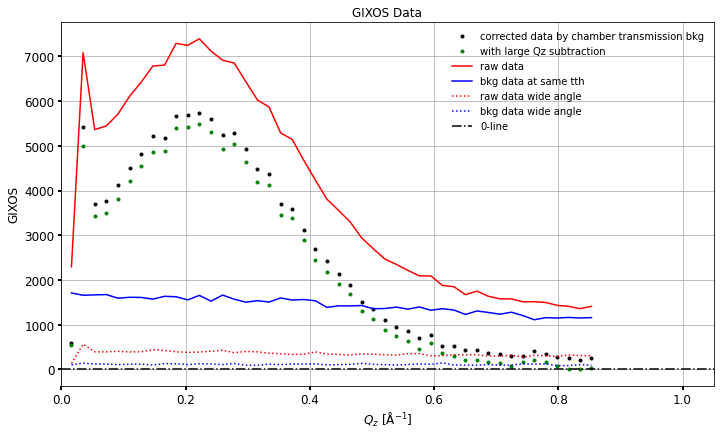

In [9]:
# is the close plot command needed here?
import os

plt.figure(figsize = (10, 6))
plt.plot(GIXOS["Qz"], GIXOS["GIXOS_raw"] - GIXOS["GIXOS_bkg"], 'ko', markersize=3, label='corrected data by chamber transmission bkg')
plt.plot(GIXOS["Qz"], GIXOS["GIXOS"], 'go', markersize=3, label='with large Qz subtraction')
plt.plot(GIXOS["Qz"], GIXOS["GIXOS_raw"], 'r-', linewidth=1.5, label='raw data')
plt.plot(GIXOS["Qz"], GIXOS["GIXOS_bkg"], 'b-', linewidth=1.5, label='bkg data at same tth')
plt.plot(GIXOS["Qz"], GIXOS_raw_largetth, 'r:', linewidth=1.5, label='raw data wide angle')
plt.plot(GIXOS["Qz"], GIXOS_bkg_largetth, 'b:', linewidth=1.5, label='bkg data wide angle')
plt.axhline(0, color='k', linestyle='-.', linewidth=1.5, label='0-line')

# --- Show legend and display
plt.legend()
plt.xlabel("Qz")
plt.ylabel("Intensity")
plt.title("GIXOS Data")
plt.grid(True)
plt.tight_layout()

plt.xlim([0, 1.05])
ax = plt.gca()

ax.set_xlabel(r'$Q_z$ [$\mathrm{\AA}^{-1}$]', fontsize=12)  # Qz with angstrom symbol
ax.set_ylabel('GIXOS', fontsize=12)

ax.set_xticks(np.arange(0, 1.01, 0.2))  # same as 0:0.2:1
ax.tick_params(axis='both', labelsize=12, width=2, direction='out')

plt.legend(loc='upper right', frameon=False)  # 'NorthEast' => 'upper right'

# --- Save figure
filename = f"{sample}_{qxy0_select_idx:05d}_GIXOS.jpg"
save_path = os.path.join(path_out, filename)
plt.savefig(save_path, dpi=300)
plt.show()


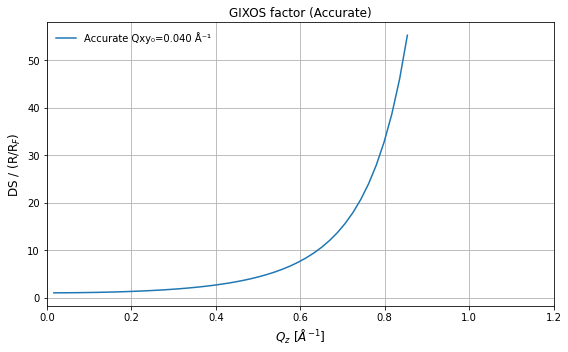

In [10]:
# NEED TO HAVE FUNCTIONS DEFINED - SEE CHEN'S CODE FOR THE FUNCTIONS

fresnel = GIXOS_fresnel(GIXOS ["Qz"], Qc) # check if fresnel == GIXOS_fresnel      SAME
Qz_array = np.asarray(GIXOS ["Qz"]).reshape(-1, 1) # done to convert GIXOS ["Qz"] from a row vetor to a column vector for GIXOS_Tsqr
transmission = GIXOS_Tsqr(Qz_array, Qc, energy, alpha_i, Ddet, footprint)  #  Mostly the same, but the 4th column starts to deviate from the MATLAB output by hundredths
dQz = GIXOS_dQz(GIXOS["Qz"], energy, alpha_i, Ddet, footprint)     # Almost same, just not iterating through enough times(?) --> missing last row      SAME now

GIXOS["DS_RRF_integ"], GIXOS["DS_term_integ"], GIXOS["RRF_term_integ"] = calc_film_DS_RRF_integ(GIXOS ["tt"], qxy0 [qxy0_select_idx], energy/1000, alpha_i, RqxyHW, DSqxyHW_real, DSbetaHW, tension, temperature, kappa, amin, use_approx=False)
# DS = Diffuse Scatter; RRF = Specular Reflectivity Normalized by Fresnel Reflectivity
# Approx form is derived from Taylor expansion, which is dependent on being close to 0 angle --> higher deviations at high angles

GIXOS["refl"] = np.column_stack([
    GIXOS["Qz"],
    GIXOS["GIXOS"] / GIXOS["DS_RRF_integ"] * fresnel[:, 1] / transmission[:, 3],
    GIXOS["error"] / GIXOS["DS_RRF_integ"] * fresnel[:, 1] / transmission[:, 3],
    dQz[:, 4]
])

GIXOS["SF"] = np.column_stack([
    GIXOS["Qz"],
    GIXOS["GIXOS"] / GIXOS["DS_term_integ"] / transmission[:, 3],
    GIXOS["error"] / GIXOS["DS_term_integ"] / transmission[:, 3],
    dQz[:, 4]
])

In [11]:
from scipy.integrate import dblquad # equivalent to integrate2() in MATLAB
#from numba import njit

xrr_config_energy = 14400

xrr_config_sdd = 1039.9
xrr_config_slit_h = 1
xrr_config_slit_v = 0.66 # not meant to be 1? - See MATLAB ig

xrr_config_wavelength = 12400/xrr_config_energy
xrr_config_wave_number = 2 * np.pi / xrr_config_wavelength
xrr_config_Qz = GIXOS["Qz"]
xrr_config_dataQz = xrr_data.iloc[:, 0].astype(float).to_numpy()  # see later bc accessing data !!!!!!!!!!!!!!!!!!!  might have bugs bc came out as strings and need to convert to float
xrr_config_beta_xrr = np.degrees(np.arcsin(xrr_config_Qz / 2 / xrr_config_wave_number))
xrr_config_beta_xrr = xrr_config_beta_xrr.reshape(-1, 1) # do this, otherwise beta_xrr has shape (46,) instead of (46, 1) which will mess up xrr_config_phi_array_for_qxy_slit_min and make it (46, 46) instead of (46, 1) like MATLAB code
xrr_config_dataRF = (( xrr_config_dataQz - np.lib.scimath.sqrt(xrr_config_dataQz**2 - Qc**2)) / (xrr_config_dataQz + np.lib.scimath.sqrt(xrr_config_dataQz**2 - Qc**2))) * np.conj((xrr_config_dataQz - np.lib.scimath.sqrt(xrr_config_dataQz**2 - Qc**2)) / (xrr_config_dataQz + np.lib.scimath.sqrt(xrr_config_dataQz**2 - Qc**2)))
xrr_config_RF = fresnel[:, 1]
xrr_config_kbT_gamma = kb * temperature / tension * 10 ** 20
xrr_config_eta = xrr_config_kbT_gamma / 2 / np.pi * xrr_config_Qz ** 2
# maybe delete xrr_config for simplicity
xrr_config_delta_phi_HW = np.degrees(np.arctan(xrr_config_slit_h / 2 / xrr_config_sdd / np.cos(np.radians(xrr_config_beta_xrr))))
xrr_config_delta_beta_HW =   np.degrees(np.arcsin(xrr_config_slit_v / 2 / xrr_config_sdd * np.cos(np.radians(xrr_config_beta_xrr))))

xrr_config_slit_h_coord = np.arange(-xrr_config_slit_h / 2, xrr_config_slit_h / 2 + 0.005, 0.005)
xrr_config_slit_v_coord = np.arange(-xrr_config_slit_v / 2, xrr_config_slit_v / 2 + 0.005, 0.005)
xrr_config_slit_t = np.column_stack((xrr_config_slit_h_coord, np.ones(len(xrr_config_slit_h_coord)) * xrr_config_slit_v / 2))  
xrr_config_slit_b = np.column_stack((xrr_config_slit_h_coord, np.ones(len(xrr_config_slit_h_coord)) * -xrr_config_slit_v / 2))
xrr_config_slit_l = np.column_stack((np.ones(len(xrr_config_slit_v_coord)) * -xrr_config_slit_h / 2, xrr_config_slit_v_coord))
xrr_config_slit_r = np.column_stack((np.ones(len(xrr_config_slit_v_coord)) * xrr_config_slit_h / 2, xrr_config_slit_v_coord))
xrr_config_slit_coord = np.concatenate((xrr_config_slit_t, xrr_config_slit_r, np.flipud(xrr_config_slit_b), np.flipud(xrr_config_slit_l)), axis = 0)
xrr_config_qxy_slit = np.zeros( (xrr_config_slit_coord.shape[0], 2, xrr_config_beta_xrr.shape[0]) )
xrr_config_qxy_slit_min = np.zeros( (xrr_config_beta_xrr.shape[0], 1) )
xrr_config_ang = np.arange(0, 2 * np.pi, 0.01)
#xrr_config_ang = xrr_config_ang.reshape(-1, 1)  # transposing to make it a column vector
xrr_config_qxy_slit_min_coord = np.zeros( (xrr_config_ang.shape[0], 2, xrr_config_qxy_slit_min.shape[0]))
for idx in range(len(xrr_config_beta_xrr)):
    xrr_config_qxy_slit[:, :, idx] = xrr_config_wave_number * np.column_stack([xrr_config_slit_coord[:, 0] / xrr_config_sdd, xrr_config_slit_coord[:, 1] / xrr_config_sdd * np.sin(np.radians(xrr_config_beta_xrr[idx]))])
    xrr_config_qxy_slit_min[idx, 0] = np.min(np.sqrt(xrr_config_qxy_slit[:, 0, idx]**2 + xrr_config_qxy_slit[:, 1, idx]**2))
    xrr_config_qxy_slit_min_coord[:, :, idx] = xrr_config_qxy_slit_min[idx] * np.column_stack([np.cos(xrr_config_ang), np.sin(xrr_config_ang)])  # might not need np.array

xrr_config_phi_max_qxy_slit_min = np.degrees(np.arctan(xrr_config_qxy_slit_min / xrr_config_wave_number / np.cos(np.radians(xrr_config_beta_xrr))))

xrr_config_phi_array_for_qxy_slit_min = xrr_config_phi_max_qxy_slit_min * np.array([0, 1/5, 2/5, 3/5, 4/5])
xrr_config_delta_beta_array_for_qxy_slit_min = np.degrees(
    np.arcsin(
        (np.sqrt(
            np.maximum(xrr_config_qxy_slit_min[:, 0:1]**2 - 
                       (np.tan(np.radians(xrr_config_phi_array_for_qxy_slit_min)) * 
                        np.cos(np.radians(xrr_config_beta_xrr)) * 
                        xrr_config_wave_number) ** 2, 0))
         / (xrr_config_wave_number * np.sin(np.radians(xrr_config_beta_xrr))))
        * np.cos(np.radians(xrr_config_beta_xrr))
    )
)

delta_beta_HW_1d = xrr_config_delta_beta_HW[:, 0]
for idx in range(xrr_config_delta_beta_array_for_qxy_slit_min.shape[1]):
    repidx = xrr_config_delta_beta_array_for_qxy_slit_min[:, idx] >= delta_beta_HW_1d
    xrr_config_delta_beta_array_for_qxy_slit_min[repidx, idx] = delta_beta_HW_1d[repidx]  # replace values that are greater than delta_beta_HW with delta_beta_HW

xrr_config_phi_array_for_qxy_slit_min = np.hstack([xrr_config_phi_array_for_qxy_slit_min, xrr_config_phi_max_qxy_slit_min]) # might not work with np.column_stack bc size mismatch --> column_hstack

xrr_config_bkgoff = 1
xrr_config_bkg_phi = np.degrees(np.arctan(xrr_config_bkgoff / (xrr_config_sdd * np.cos(np.radians(xrr_config_beta_xrr)))))   # off by ten thousandths place - supposed to get larger as index increases, but decreases instead?


xrr_config_r_step = 0.001
xrr_config_r = np.sqrt(np.maximum(np.arange(0.001, 8*round(Lk) + xrr_config_r_step, xrr_config_r_step) ** 2 + amin ** 2, 0))
xrr_config_C_integrand = np.zeros((len(xrr_config_Qz), len(xrr_config_r)))
for idx in range(len(xrr_config_Qz)):
    xrr_config_C_integrand[idx, :] = 2 * np.pi * xrr_config_r**(1 - xrr_config_eta[idx]) * (np.exp(-xrr_config_eta[idx] * besselk(0, xrr_config_r / Lk)) - 1)    # off by thousandths place
# Matches up till here

xrr_config_C = np.sum(xrr_config_C_integrand, axis = 1) * xrr_config_r_step
xrr_config_qxy_slit_min_flat = xrr_config_qxy_slit_min.flatten()  # (46,) so that RRF_term does not return a (46, 46) array since MATLAB returns a (46, 1)
xrr_config_RRF_term = (xrr_config_qxy_slit_min_flat ** xrr_config_eta + xrr_config_qxy_slit_min_flat ** 2 * xrr_config_C / 4 / np.pi) * (1/qmax) ** xrr_config_eta * np.exp(xrr_config_eta * besselk(0, 1 / Lk / qmax))
xrr_config_specular_qxy_min = xrr_config_RF * xrr_config_RRF_term # off by hundredths/thousandths

xrr_config_region_around_radial_u_r = np.zeros((len(xrr_config_beta_xrr), xrr_config_delta_beta_array_for_qxy_slit_min.shape[1]))    # off by ~5-8 thousandths
xrr_config_region_around_radial_l_r = np.zeros((len(xrr_config_beta_xrr), xrr_config_delta_beta_array_for_qxy_slit_min.shape[1]))    # off by ~5-8 thousandths
xrr_config_diff_r = np.zeros((len(xrr_config_beta_xrr), 1))    # VERY OFF
xrr_config_diff_r_bkgoff = np.zeros((len(xrr_config_beta_xrr), 1))    # VERY OFF

xrr_config_diff_r = xrr_config_diff_r.flatten()
xrr_config_diff_r_bkgoff = xrr_config_diff_r_bkgoff.flatten()

for idx in range(len(xrr_config_beta_xrr)):
    fun_film = lambda tt, tth: film_integral_approx_delta_beta_delta_phi(tt, tth, xrr_config_kbT_gamma, xrr_config_wave_number, xrr_config_beta_xrr[idx], Lk, amin)
    for phi_idx in range(xrr_config_delta_beta_array_for_qxy_slit_min.shape[1]):
        upper, _ = dblquad(lambda tth, tt: fun_film(tt, tth), (xrr_config_beta_xrr[idx] + xrr_config_delta_beta_array_for_qxy_slit_min[idx, phi_idx]), (xrr_config_beta_xrr[idx] + xrr_config_delta_beta_HW[idx]), lambda _: xrr_config_phi_array_for_qxy_slit_min[idx, phi_idx], lambda _: xrr_config_phi_array_for_qxy_slit_min[idx, phi_idx + 1], epsabs=1e-10 , epsrel=1e-6)
        xrr_config_region_around_radial_u_r[idx, phi_idx] = upper * (np.pi/180) ** 2 * (9.42e-6)**2 / np.sin(np.radians(xrr_config_beta_xrr[idx]))

        lower, _ = dblquad(lambda tth, tt: fun_film (tt, tth), (xrr_config_beta_xrr[idx] - xrr_config_delta_beta_HW[idx]), (xrr_config_beta_xrr[idx] - xrr_config_delta_beta_array_for_qxy_slit_min[idx, phi_idx]), lambda _: xrr_config_phi_array_for_qxy_slit_min[idx, phi_idx], lambda _: xrr_config_phi_array_for_qxy_slit_min[idx, phi_idx + 1], epsabs=1e-10, epsrel=1e-6)
        xrr_config_region_around_radial_l_r[idx, phi_idx] = lower * (np.pi/180)**2 * (9.42e-6)**2 / np.sin(np.radians(xrr_config_beta_xrr[idx]))

    # Run the integral
    result, _ = dblquad(
    func=fun_film,
    a = xrr_config_beta_xrr[idx] - xrr_config_delta_beta_HW[idx],
    b = xrr_config_beta_xrr[idx] + xrr_config_delta_beta_HW[idx],
    gfun=lambda beta: xrr_config_phi_max_qxy_slit_min[idx],
    hfun=lambda beta: xrr_config_phi_max_qxy_slit_min[idx] + xrr_config_delta_phi_HW[idx]
    )

# Store the result (second column, index 0 in Python)
    xrr_config_diff_r[idx] = (result * (np.pi / 180)**2 * (9.42e-6)**2 / np.sin(np.deg2rad(xrr_config_beta_xrr[idx])))
        
    result2, _ = dblquad(func=fun_film,
    a=xrr_config_beta_xrr[idx] - xrr_config_delta_beta_HW[idx],
    b=xrr_config_beta_xrr[idx] + xrr_config_delta_beta_HW[idx],
    gfun=lambda beta: xrr_config_bkg_phi[idx] - xrr_config_delta_phi_HW[idx],
    hfun=lambda beta: xrr_config_bkg_phi[idx] + xrr_config_delta_phi_HW[idx]
    )
    xrr_config_diff_r_bkgoff[idx] = diff_r_bkgoff = (result2 * (np.pi / 180)**2 * (9.42e-6)**2 / np.sin(np.deg2rad(xrr_config_beta_xrr[idx])))



xrr_config_Rterm_rect_slit = xrr_config_specular_qxy_min + 2*(np.sum(xrr_config_region_around_radial_u_r + xrr_config_region_around_radial_u_r, axis = 1) + xrr_config_diff_r)
xrr_config_bkgterm_rect_slit = xrr_config_diff_r_bkgoff

# integration might be wrong; Rterm seems close enough, but bkgterm is off by a lot


In [12]:
numerator_scaling = (xrr_config_Rterm_rect_slit - xrr_config_bkgterm_rect_slit)
denominator = GIXOS["DS_term_integ"] * transmission[:, 3]  # Element-wise multiplication

refl_recSlit = np.column_stack([
    GIXOS["Qz"],
    GIXOS["GIXOS"] * numerator_scaling / denominator,
    GIXOS["error"] * numerator_scaling / denominator,
    dQz[:, 4]
])

refl_roughness_term = (xrr_config_Rterm_rect_slit - xrr_config_bkgterm_rect_slit) / xrr_config_RF
refl_roughness = np.sqrt(-np.log(refl_roughness_term) / GIXOS["Qz"]**2)
GIXOS["SF"] = np.column_stack([GIXOS["SF"], refl_roughness, refl_roughness_term])

In [13]:
# Output file creation

# ---- FILE 1: Pseudo Reflectivity ----
xrrfilename = f"{path_out}{sample}_{scan[qxy0_select_idx]:05d}_R_PYTHON.dat"
with open(xrrfilename, 'w') as f:
    f.write(f"# files\n")
    f.write(f"sample file: {sample}-id{scan[qxy0_select_idx]}\n")
    f.write(f"background file: {bkgsample}-id{bkgscan[qxy0_select_idx]}\n")
    f.write(f"wide angle bkg at qxy0 = {qxy_bkg:.6f} /A\n")
    f.write(f"# geometry\n")
    f.write(f"energy [eV]: {energy:.2f}\n")
    f.write(f"incidence [deg]: {alpha_i}\n")
    f.write(f"footprint [mm]: {footprint:.1f}\n")
    f.write(f"sdd [mm]: {Ddet:.2f}\n")
    f.write(f"qxy resolution HWHM at specular [A^-1]: {DSresHW}\n")
    f.write(f"phi_opening [deg]: {tth_roiHW_real}\n")
    f.write(f"beta_step [deg]: {tt_step}\n")
    f.write(f"# DS-XRR conversion optics setting\n")
    f.write(f"phi [deg]: {tth}\n")
    f.write(f"qxy(beta=0) [A^-1]: {qxy0[qxy0_select_idx]}\n")
    f.write(f"phi integration HW [deg]: {tth_roiHW_real}\n")
    f.write(f"corresponding qxy HW [A^-1]: {DSqxyHW_real}\n")
    f.write(f"R slit: {xrr_config_slit_v} mm (v) {xrr_config_slit_h} mm (h) at {xrr_config_sdd} mm distance, {xrr_config_energy} eV beam energy\n")
    f.write(f"scaling: {RFscaling}\n")
    f.write(f"# DS-XRR conversion sample setting\n")
    f.write(f"tension [N/m]: {tension}\n")
    f.write(f"temperature [K]: {temperature:.1f}\n")
    f.write(f"kappa [kbT]: {kappa:.1f}\n")
    f.write(f"CW short cutoff [A]: {amin}\n")
    f.write(f"CW and Kapa roughness [A]: {refl_roughness[0]} to {refl_roughness[-1]}\n")
    f.write("# data\nqz\tR\tdR\tdqz\n[A^-1]\t[a.u.]\t[a.u.]\t[A^-1]\n")

# Save reflectivity data
with open(xrrfilename, 'a') as f:
    np.savetxt(f, refl_recSlit, delimiter='\t', fmt='%.6e')
#    np.savetxt(f, refl_recSlit, delimiter='\t', fmt='%.6e', comments='', header='', encoding='utf-8', newline='\n', append=True)


# ---- FILE 2: DS/(R/RF) ----
ds2rrf_filename = f"{path_out}{sample}_{scan[qxy0_select_idx]:05d}_DS2RRF_PYTHON.dat"
with open(ds2rrf_filename, 'w') as f:
    f.write(f"# files\n")
    f.write(f"sample file: {sample}-id{scan[qxy0_select_idx]}\n")
    f.write(f"background file: {bkgsample}-id{bkgscan[qxy0_select_idx]}\n")
    f.write(f"wide angle bkg at qxy0 = {qxy_bkg:.6f} /A\n")
    f.write(f"# geometry\n")
    f.write(f"energy [eV]: {energy:.2f}\n")
    f.write(f"incidence [deg]: {alpha_i}\n")
    f.write(f"footprint [mm]: {footprint:.1f}\n")
    f.write(f"sdd [mm]: {Ddet:.2f}\n")
    f.write(f"qxy resolution HWHM at specular [A^-1]: {DSresHW}\n")
    f.write(f"phi_opening [deg]: {tth_roiHW_real}\n")
    f.write(f"beta_step [deg]: {tt_step}\n")
    f.write(f"# DS-XRR conversion optics setting\n")
    f.write(f"phi [deg]: {tth}\n")
    f.write(f"qxy(beta=0) [A^-1]: {qxy0[qxy0_select_idx]}\n")
    f.write(f"phi integration HW [deg]: {tth_roiHW_real}\n")
    f.write(f"corresponding qxy HW [A^-1]: {DSqxyHW_real}\n")
    f.write(f"R slit: {xrr_config_slit_v} mm (v) {xrr_config_slit_h} mm (h) at {xrr_config_sdd} mm distance, {xrr_config_energy} eV beam energy\n")
    f.write(f"scaling: {RFscaling}\n")
    f.write(f"# DS-XRR conversion sample setting\n")
    f.write(f"tension [N/m]: {tension}\n")
    f.write(f"temperature [K]: {temperature:.1f}\n")
    f.write(f"kappa [kbT]: {kappa:.1f}\n")
    f.write(f"CW short cutoff [A]: {amin}\n")
    f.write(f"CW and Kapa roughness [A]: {refl_roughness[0]} to {refl_roughness[-1]}\n")
    f.write("# data\nqz\tDS/(R/RF)\n[A^-1]\t[a.u.]\n")

ds_over_rrf = GIXOS["DS_term_integ"] / (xrr_config_Rterm_rect_slit / xrr_config_RF)
with open(ds2rrf_filename, 'a') as f:
    np.savetxt(f, np.column_stack((GIXOS["Qz"], ds_over_rrf)), delimiter='\t', fmt='%.6e')
#     np.savetxt(f, np.column_stack((GIXOS["Qz"], ds_over_rrf)), delimiter='\t', fmt='%.6e', comments='', header='', encoding='utf-8', newline='\n', append=True)


# ---- FILE 3: Structure Factor ----
sf_filename = f"{path_out}{sample}_{scan[qxy0_select_idx]:05d}_SF_PYTHON.dat"
with open(sf_filename, 'w') as f:
    f.write(f"# pure structure factor and kapa/cw roughness with its decay term under given XRR resolution\n")
    f.write(f"# files\nsample file: {sample}-id{scan[qxy0_select_idx]}\n")
    f.write(f"background file: {bkgsample}-id{bkgscan[qxy0_select_idx]}\n")
    f.write(f"wide angle bkg at qxy0 = {qxy_bkg:.6f} /A\n")
    f.write(f"# geometry\n")
    f.write(f"energy [eV]: {energy:.2f}\n")
    f.write(f"incidence [deg]: {alpha_i}\n")
    f.write(f"footprint [mm]: {footprint:.1f}\n")
    f.write(f"sdd [mm]: {Ddet:.2f}\n")
    f.write(f"qxy resolution HWHM at specular [A^-1]: {DSresHW}\n")
    f.write(f"phi_opening [deg]: {tth_roiHW_real}\n")
    f.write(f"beta_step [deg]: {tt_step}\n")
    f.write(f"# DS-XRR conversion optics setting\n")
    f.write(f"phi [deg]: {tth}\n")
    f.write(f"qxy(beta=0) [A^-1]: {qxy0[qxy0_select_idx]}\n")
    f.write(f"phi integration HW [deg]: {tth_roiHW_real}\n")
    f.write(f"corresponding qxy HW [A^-1]: {DSqxyHW_real}\n")
    f.write(f"R slit: {xrr_config_slit_v} mm (v) {xrr_config_slit_h} mm (h) at {xrr_config_sdd} mm distance, {xrr_config_energy} eV beam energy\n")
    f.write(f"scaling: {RFscaling}\n")
    f.write(f"# DS-XRR conversion sample setting\n")
    f.write(f"tension [N/m]: {tension}\n")
    f.write(f"temperature [K]: {temperature:.1f}\n")
    f.write(f"kappa [kbT]: {kappa:.1f}\n")
    f.write(f"CW short cutoff [A]: {amin}\n")
    f.write(f"CW and Kapa roughness [A]: {refl_roughness[0]} to {refl_roughness[-1]}\n")
    f.write("# data\nqz\tSF\tdSF\tdQz\tsigma_R\texp(-qz2sigma2)\n[A^-1]\t[a.u.]\t[a.u.]\t[A^-1]\t[A^-1]\t[a.u.]\n")

with open(sf_filename, 'a') as f:
    np.savetxt(f, GIXOS["SF"], delimiter='\t', fmt='%.6e')
#     np.savetxt(f, GIXOS["SF"], delimiter='\t', fmt='%.6e', comments='', header='', encoding='utf-8', newline='\n', append=True)


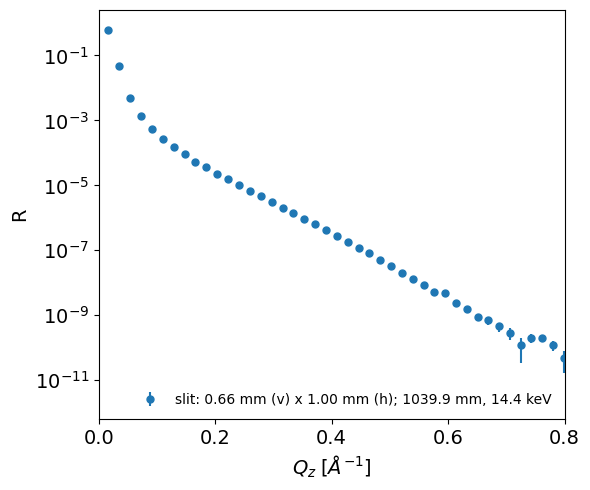

In [ ]:
# Final Two Graphs Below
refl_recSlit = np.array(refl_recSlit)

# Close any existing figure named 'refl'
plt.close('refl')

# Create new figure
fig, ax = plt.subplots(num='refl', figsize=(6, 5))
fig.canvas.manager.set_window_title('refl')

# Plot error bars
# Commented line corresponds to the MATLAB commented errorbar line
# ax.errorbar(GIXOS['refl'][:,0], GIXOS['refl'][:,1]/RFscaling, yerr=GIXOS['refl'][:,2]/RFscaling,
#             fmt='o', markersize=3,
#             label=f"δQ_xy= {geo['RqxyHW']:.1e} Å⁻¹")

ax.errorbar(
    refl_recSlit[:, 0],
    refl_recSlit[:, 1] / RFscaling,
    yerr=refl_recSlit[:, 2] / RFscaling,
    fmt='o',
    markersize=5,
    label=(
        f"slit: {xrr_config_slit_v:.2f} mm (v) x {xrr_config_slit_h:.2f} mm (h); "
        f"{xrr_config_sdd:.1f} mm, {xrr_config_energy / 1000:.1f} keV"
    )
)

ax.set_xlim(0, 0.8)
ax.set_xlabel(r'$Q_z \; [\AA^{-1}]$', fontsize=14)
ax.set_ylabel('R', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14, direction='out')
ax.set_xticks(np.arange(0, 0.81, 0.2))
ax.set_yscale('log')
ax.legend(loc='lower right', frameon=False)  # 'Southeast' → 'lower right' in matplotlib

plt.tight_layout()

# Save figure
filename = f"{path_out}{sample}_{scan[qxy0_select_idx]:05d}_R_PYTHON.jpg"
plt.savefig(filename, dpi=300)
plt.show()


/Users/xiaogangyang/miniforge3/envs/general-data/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/xiaogangyang/miniforge3/envs/general-data/lib/python3.10/site-packages/numpy/ma/core.py:3375: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


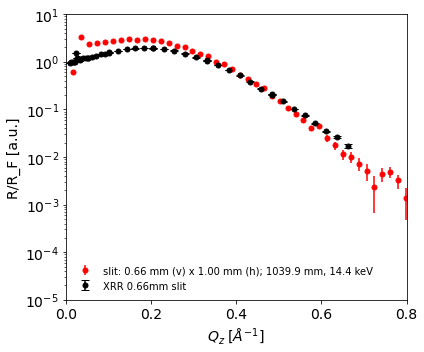

In [14]:
# Ensure relevant arrays are numpy arrays
refl_recSlit = np.array(refl_recSlit)
fresnel = np.array(fresnel)
xrr_data_data = np.array(xrr_data)

# Close existing figure named 'RRF'
plt.close('RRF')

fig, ax = plt.subplots(num='RRF', figsize=(6, 5))
fig.canvas.manager.set_window_title('RRF')

# Plot first errorbar: refl_recSlit normalized by fresnel and RFscaling
ax.errorbar(
    refl_recSlit[:, 0],
    refl_recSlit[:, 1] / fresnel[:, 1] / RFscaling,
    yerr=refl_recSlit[:, 2] / fresnel[:, 1] / RFscaling,
    fmt='ro',
    markersize=5,
    linewidth=1.5,
    label=(
        f"slit: {xrr_config_slit_v:.2f} mm (v) x {xrr_config_slit_h:.2f} mm (h); "
        f"{xrr_config_sdd:.1f} mm, {xrr_config_energy / 1000:.1f} keV"
    )
)

# Plot second errorbar: xrr_data normalized by dataRF
ax.errorbar(
    xrr_data_data[:, 0],
    xrr_data_data[:, 1] / xrr_config_dataRF,
    yerr=xrr_data_data[:, 2] / xrr_config_dataRF,
    fmt='ko',
    markersize=5,
    linewidth=1.5,
    capsize=4,
    label='XRR 0.66mm slit'
)

ax.set_xlim(0, 0.8)
ax.set_ylim(1e-5, 10)
ax.set_xlabel(r'$Q_z \; [\AA^{-1}]$', fontsize=14)
ax.set_ylabel('R/R_F [a.u.]', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14, direction='out')
ax.set_xticks(np.arange(0, 0.81, 0.2))
ax.set_yscale('log')
ax.legend(loc='lower left', frameon=False)  # MATLAB 'SouthWest' ≈ matplotlib 'lower left'

plt.tight_layout()

filename = f"{path_out}{sample}_{scan[qxy0_select_idx]:05d}_RRF_PYTHON.jpg"
plt.savefig(filename, dpi=300)
plt.show()
